# Ermetal notebook
## SPDX-FileName: Price forecasting ERMETAL.ipynb
## SPDX-FileCopyrightText: Copyright 2010 - 2025 Software GmbH, Darmstadt, Germany and/or its subsidiaries and/or its affiliates
## SPDX-License-Identifier: Apache-2.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator
import pickle
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import sklearn.metrics
import seaborn as sn
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import KFold

: 

## Reading Data sources

In [2]:
high_carbon       = pd.read_csv('1.2379 High carbon tool steel.csv')
medium_carbon     = pd.read_csv('C1050 Medium Carbon Steel.csv')
nonalloy_cast     = pd.read_csv('G50CrMo4 Cast non-alloy and low alloy steels.csv')
grey_cast_iron    = pd.read_csv('GG25 Grey cast iron material.csv')
nodular_cast_iron = pd.read_csv('GGG60 Nodularcastiron.csv')
low_carbon        = pd.read_csv('ST37 Low carbon steel.csv')
material_weights  = pd.read_excel('Sheet Metal Stamping Die Materials.xlsx')

In [3]:
high_carbon.rename(columns={"WPU11350146": "High_carbon"}, inplace = True)
medium_carbon.rename(columns={"WPU10170802": "Medium_carbon"}, inplace = True)
nonalloy_cast.rename(columns={"WPU10150901": "nonalloy_cast"}, inplace = True)
grey_cast_iron.rename(columns={"WPU10150419": "grey_cast_iron"}, inplace = True)
nodular_cast_iron.rename(columns={"WPU10150413": "nodular_cast_iron"}, inplace = True)
low_carbon.rename(columns={"PCU33211133211111": "low_carbon"}, inplace = True)

In [4]:
#merged_df['High_carbon'].fillna(merged_df['High_carbon'].mean(), inplace=True)
high_carbon = high_carbon.replace('.', np.nan)
high_carbon['High_carbon'] = high_carbon['High_carbon'].astype(float)

In [5]:
# adding exterior possible influencing variables
inflation_df = pd.read_csv("Inflation (CPI).csv")
crude_oil_df = pd.read_csv("Crude oil import prices.csv")
st_interest_rate_df = pd.read_csv("Short-term interest rates.csv")
lt_interest_rate_df = pd.read_csv("Long-term interest rates.csv")
natural_gas = pd.read_csv("Global price of Natural gas.csv")
labor_cost = pd.read_csv("Labour compensation per hour worked_tur.csv")
dollar_euro_conversion_rate = pd.read_csv("USD_EUR=X.csv")
big_mac = pd.read_csv("big-mac-source-data-v2.csv")
eur_tur_conversion_rate = pd.read_csv("EURTRY=X.csv")

# financial data from turkey
Purchasing_power_parities_df = pd.read_excel("PPP.xls")
consumer_price_index = pd.read_csv("CPI in turkey.csv") 

## Cleaning and preprocessing Dataframes

In [6]:
labor_cost = labor_cost[labor_cost['LOCATION'] == 'TUR'].reset_index(drop = True)[['TIME', 'Value']]
labor_cost.rename(columns={'TIME': 'Date', 'Value': 'labor_cost'}, inplace=True)
labor_cost['Date'] = pd.to_datetime(labor_cost['Date'], format='%Y')
labor_cost = labor_cost.set_index('Date').resample('MS').ffill().reset_index()

In [7]:
Purchasing_power_parities_cleaned = Purchasing_power_parities_df.copy()
new_labels = Purchasing_power_parities_cleaned.iloc[2].tolist()
Purchasing_power_parities_cleaned.columns = new_labels
# get the turkish row values(35) and remove first and last column
Purchasing_power_parities_cleaned = Purchasing_power_parities_cleaned.iloc[[35],1:-1]
Purchasing_power_parities_cleaned = Purchasing_power_parities_cleaned.T.reset_index()
Purchasing_power_parities_cleaned.columns = ['Date', 'PPP']
Purchasing_power_parities_cleaned['Date'] = pd.to_datetime(Purchasing_power_parities_cleaned['Date'], format='%Y')
# transform it into monthly frequency
Purchasing_power_parities_cleaned = Purchasing_power_parities_cleaned.set_index('Date').resample('MS').ffill().reset_index()

In [ ]:
# get the first 24 rows and remove last column
consumer_price_index_clean = consumer_price_index.iloc[:24,:-1]
# Retrieve the values of the second row
new_labels = consumer_price_index_clean.iloc[2].tolist()

# Assign the new labels to the DataFrame
consumer_price_index_clean.columns = new_labels

# remove the first three rows
consumer_price_index_clean = consumer_price_index_clean.iloc[3:]
consumer_price_index_clean = consumer_price_index_clean.reset_index(drop=True)
#rename Nan column
consumer_price_index_clean.rename(columns={consumer_price_index_clean.columns[0]: 'Date'}, inplace=True)
# Melt the DataFrame to transform it into 'Date' and 'Value' columns
consumer_price_index_clean = pd.melt(consumer_price_index_clean, id_vars=['Date'], var_name='Month', value_name='CPI')
#transform to datetime type
consumer_price_index_clean['Date'] = pd.to_datetime(consumer_price_index_clean['Date'].astype(str) + '-' + consumer_price_index_clean['Month'], format='%Y-%B')
#removing month column and sorting WRT year
consumer_price_index_clean.drop(columns=['Month'], inplace=True)
consumer_price_index_clean.sort_values(by='Date', inplace=True)
consumer_price_index_clean.reset_index(drop=True, inplace=True)
consumer_price_index_clean

In [ ]:
gas_dates = natural_gas['DATE'].values
gas_prices = natural_gas['PNGASEUUSDM'].values
# preprocessing Gas data
count = 0
gas_sum = 0
avg_count = 0
gas_map = {}
while count < len(gas_dates) - 1:
    if gas_dates[count][0:4] == gas_dates[count + 1][0:4]:
        gas_sum += gas_prices[count]
        avg_count += 1
    else:
        gas_sum += gas_prices[count]
        average = gas_sum / avg_count + 1
        gas_map[gas_dates[count][0:4]] = average
        gas_sum = 0
        avg_count = 0
    count += 1
    
print(gas_map)

In [10]:
count = 0
while count < len(gas_dates) - 1:
    if gas_dates[count][0:4] == gas_dates[count + 1][0:4]:
        gas_sum += gas_prices[count]
        avg_count += 1
    else:
        gas_sum += gas_prices[count]
        average = gas_sum / avg_count + 1
        gas_map[gas_dates[count][0:4]] = average
        gas_sum = 0
        avg_count = 0
    count += 1

In [ ]:
gas_prices = pd.DataFrame.from_dict(gas_map, orient='index', columns = ['gas_price'])
gas_prices.index.name = 'TIME'
gas_prices.index = gas_prices.index.astype('int64')
crude_oil_df = crude_oil_df.groupby(['TIME']).mean().rename(columns={'Value':'crude_oil'})

In [ ]:
financial_data = pd.merge(consumer_price_index_clean, Purchasing_power_parities_cleaned, on='Date', how = 'left')
financial_data = pd.merge(financial_data,labor_cost, on = 'Date')
financial_data

In [13]:
energy_cost = pd.merge(gas_prices, crude_oil_df, on = 'TIME')

In [ ]:
energy_cost['gas_price'].corr(energy_cost['crude_oil'])

In [15]:
# processing energy features and transforming into monthly frequency
energy_cost = energy_cost.reset_index().rename(columns={'TIME': 'date'})
energy_cost['date'] = pd.to_datetime(energy_cost['date'], format='%Y')
energy_cost_monthly = energy_cost.set_index('date').resample('M').ffill().reset_index()

In [ ]:
# plot energy data
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 6)
plt.title('Energy data')
plt.ylabel('value')
energy_cost_monthly.set_index('date').plot(ax = ax);
# Show the plot
plt.show()

In [ ]:
financial_data

In [ ]:
financial_data['Date'] = pd.to_datetime(financial_data['Date'])
fig, ax = plt.subplots(figsize=(10, 6))

columns_to_plot = ['PPP', 'labor_cost', 'CPI', 'Date']

# Plot all selected columns on the same y-axis
for column in columns_to_plot[:-1]:  # Exclude 'date' from y-axis plotting
    ax.plot(financial_data['Date'], financial_data[column], label=column)

# Adjusting the layout of the left y-axis ticks
ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(MultipleLocator(base=100))

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.title('Time Series Plot of {}'.format(', '.join(columns_to_plot[:-1])))  # Exclude 'date' from the title
plt.legend(loc='upper left')

# Show the plot
plt.show()

In [ ]:
financial_data

In [20]:
merged_df = pd.merge(high_carbon, medium_carbon, on='DATE', how = 'left')
merged_df = pd.merge(merged_df, nonalloy_cast, on='DATE')
merged_df = pd.merge(merged_df, grey_cast_iron, on='DATE')
merged_df = pd.merge(merged_df, nodular_cast_iron, on='DATE')
merged_df = pd.merge(merged_df, low_carbon, on='DATE')
merged_df = merged_df.replace('.', np.nan)

In [ ]:
# convert string type of some columns to float
object_columns = merged_df.iloc[:, 1:].select_dtypes(include='object').columns
print(object_columns)
merged_df[object_columns] = merged_df[object_columns].astype(float)

In [ ]:
merged_df

In [23]:
merged_df['date'] = pd.to_datetime(merged_df['DATE'])
merged_df.drop('DATE', axis = 1, inplace = True)

In [24]:
financial_data['date'] = financial_data['Date'].dt.to_period('M')
merged_df['date'] = merged_df['date'].dt.to_period('M')
energy_cost_monthly['date'] = energy_cost_monthly['date'].dt.to_period('M')

In [25]:
## we decided to remove this as it compromises the model ability to capture the original pattern and instead captures the pattern of 
# dollar to euro conversion rate

# adjust the material price trend values from USD to EUR
# Iterate through the columns
#for column in merged_df.columns:
#    # Iterate through the values in the column
#    for index, value in enumerate(merged_df[column]):
#        if column != 'date':
             # Get the corresponding conversion rate for this row
#            conversion_rate = dollar_euro_conversion_rate['Open'].iloc[index]
            
            # Multiply the value in the column by the conversion rate
#            merged_df.at[index, column] *= conversion_rate
#merged_df

In [26]:
joined_data = pd.merge(financial_data, merged_df, on='date', how = 'outer')
joined_data.drop('Date', axis=1, inplace=True)
joined_data = pd.merge(joined_data, energy_cost_monthly, on='date', how = 'left')

In [ ]:
energy_cost_monthly

In [ ]:
joined_data

In [29]:
# Convert 'DATE' column to datetime type
joined_data['date'] = joined_data['date'].dt.to_timestamp()
joined_data['date'] = pd.to_datetime(joined_data['date'])
# Extract year, month, and day as separate features
joined_data['Year'] = joined_data['date'].dt.year
joined_data['Month'] = joined_data['date'].dt.month

In [30]:
joined_data = joined_data.query('Year <= 2021 and Year >= 2012').reset_index(drop = True)

In [31]:
#interpolating for missing values
columns_to_interpolate = joined_data.columns.difference(['date','Year','Month'])

for column in columns_to_interpolate:
    joined_data[column].interpolate(method='linear',inplace = True)
#joined_data.interpolate(method='bfill',inplace = True)

In [ ]:
# plot of original metal price trends
ax = plt.gca()
fig = ax.get_figure()
fig.set_size_inches(10, 6)

merged_df.set_index('date').plot(ax = ax);

# Show the plot
plt.show()

In [ ]:
material_weights.head()

In [34]:
# remove first three columns
material_weights_cleaned = material_weights.iloc[:,5:]

In [ ]:
material_weights_cleaned.head()

In [36]:
# Retrieve the values of the second row
new_labels = material_weights_cleaned.iloc[1].tolist()

# Assign the new labels to the DataFrame
material_weights_cleaned.columns = new_labels

# remove the first four rows
material_weights_cleaned = material_weights_cleaned.iloc[4:]
material_weights_cleaned = material_weights_cleaned.reset_index(drop=True)

In [37]:
material_weights_cleaned = material_weights_cleaned.rename(columns={'G50CrMo4': 'nonalloy_cast',
                        'GG25'  : 'grey_cast_iron',
                        'GGG60' : 'nodular_cast_iron',
                        '1.2379': 'high_carbon',
                        'ST37'  : 'low_carbon',
                        'C1050' : 'medium_carbon',
                        np.nan  :'labor_hours'})

In [ ]:
material_weights_cleaned.head()

In [ ]:
#get first row
first_product_type_weights = material_weights_cleaned.iloc[0,:7]
labour_hours = material_weights_cleaned.iloc[0,7]
first_product_type_weights

In [40]:
# calculate potential final product price
for index, row in joined_data.interpolate('ffill').iterrows():
    accumulated_price = (first_product_type_weights['high_carbon'] * row['High_carbon']        +
                        first_product_type_weights['medium_carbon'] * row['Medium_carbon']     +
                        first_product_type_weights['nonalloy_cast'] * row['nonalloy_cast']     +
                        first_product_type_weights['grey_cast_iron'] * row['grey_cast_iron']   +
                        first_product_type_weights['nodular_cast_iron'] * row['nodular_cast_iron'] +
                        first_product_type_weights['low_carbon'] * row['low_carbon'])
    joined_data.loc[index, 'accumulated_price'] = accumulated_price

In [41]:
# multiply labour cost values with the hours it took in production
joined_data['labor_cost'] = joined_data['labor_cost'] * labour_hours 

In [ ]:
joined_data

In [ ]:
joined_data.corr()

In [ ]:
plt.figure(figsize=(10, 6))
sn.heatmap(joined_data[joined_data.columns.difference(['Year','Month'])].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Creating the figure and axes
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 10)

# Plotting the first y-axis (other columns except 'accumulated_price')
columns_to_plot = joined_data.columns.difference(['date', 'accumulated_price', 'Year', 'Month', 'index', 'labor_cost'])
for column in columns_to_plot:
    ax1.plot(joined_data['date'], joined_data[column], label=column)

# Setting labels and legends for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Values')
ax1.legend(loc='upper right')
plt.title('Accumulated price across time with affecting features')
# Adjusting the layout of the left y-axis ticks
ax1.yaxis.set_major_locator(MaxNLocator(prune='both'))
# Creating the second y-axis for 'accumulated_price'
ax2 = ax1.twinx()
ax2.plot(joined_data['date'], joined_data['accumulated_price'], color='green', label='Accumulated Price')
ax2.set_ylabel('Accumulated Price')
ax2.legend(loc='upper left')

# Displaying the plot
plt.show()

# prediction Models

In [46]:
# Convert 'DATE' column to datetime type
joined_data['date'] = pd.to_datetime(joined_data['date'])

# Extract year, month, and day as separate features
joined_data['Year'] = joined_data['date'].dt.year
joined_data['Month'] = joined_data['date'].dt.month

# Drop the original 'DATE' column
joined_data = joined_data.drop('date', axis=1)

In [47]:
from sklearn.model_selection import train_test_split
# Splitting into features (X) and target (y)
X = joined_data.drop('accumulated_price', axis=1).values  # Features (all columns except 'accumulated_price')
y = joined_data['accumulated_price'].values  # Target variable
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [48]:
from sklearn.linear_model import LinearRegression

# Create an instance of the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [49]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 7.270366130599411e-20


## Deep learning models

In [50]:
joined_data

,CPI,PPP,labor_cost,High_carbon,Medium_carbon,nonalloy_cast,grey_cast_iron,nodular_cast_iron,low_carbon,gas_price,crude_oil,Year,Month,accumulated_price
0,201.98,1.019856,7410.907,100.000,109.1,149.700,101.300,154.200,183.300,14.070000,111.735000,2012,1,481000.9500
1,203.12,1.019856,7410.907,100.400,108.5,149.800,102.100,156.600,183.300,14.070000,111.735000,2012,2,483405.0900
2,203.96,1.019856,7410.907,100.400,108.4,149.900,101.800,154.800,185.600,14.070000,111.735000,2012,3,484333.4400
3,207.05,1.019856,7410.907,100.600,108.1,149.600,101.800,154.900,184.900,14.070000,111.735000,2012,4,483529.6100
4,206.61,1.019856,7410.907,100.800,106.2,149.800,101.400,155.100,184.500,14.070000,111.735000,2012,5,482897.3800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,563.60,2.807879,12185.733,115.431,117.3,162.379,118.876,173.658,188.295,18.353487,70.366154,2021,8,524912.5416
116,570.66,2.807879,12185.733,116.736,117.3,163.475,118.990,174.107,188.295,18.353487,70.366154,2021,9,526020.1796
117,584.32,2.807879,12185.733,117.513,117.3,163.857,124.473,174.010,188.987,18.353487,70.366154,2021,10,532566.2688
118,604.84,2.807879,12185.733,117.513,117.3,163.978,124.413,176.014,191.104,18.353487,70.366154,2021,11,535975.8368


In [51]:
#splitting data to training and testing sets
train_size = int(len(joined_data) * 0.8)
train_data, test_data = joined_data[:train_size], joined_data[train_size:]

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1, :])
        return y_pred

In [53]:
# Create sequences for training
def create_sequences(dataset, look_back):
    data_X, data_Y = [], []
    for i in range(len(dataset) - look_back):
        data_X.append(dataset[i:(i + look_back), :])
        data_Y.append(dataset[i + look_back, -1])  # Target column is the last one in the sequence
    return np.array(data_X), np.array(data_Y)

In [54]:
def train_lstm_model_with_early_stopping(df, target_column='accumulated_price', look_back=1, num_epochs=100, batch_size=32, lr=0.001, n_splits=5, patience=10):
    """
    Train an LSTM model for timeseries forecasting using PyTorch with early stopping using k-fold cross-validation.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing the timeseries data.
        target_column (str): The column to forecast.
        look_back (int): Number of previous time steps to use as input for each prediction.
        num_epochs (int): Maximum number of training epochs per fold.
        batch_size (int): Batch size for training.
        lr (float): Learning rate for the optimizer.
        n_splits (int): Number of splits for k-fold cross-validation.
        patience (int): Number of epochs with no improvement to wait before early stopping.

    Returns:
        model (LSTMModel): The trained LSTM model.
        scaler (sklearn.preprocessing.MinMaxScaler): The MinMaxScaler used for normalization.
    """
    # Extract the target column and the features for training
    target_data = df[target_column].values.reshape(-1, 1)
    feature_data = df.drop(columns=[target_column]).values

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)

    # Combine features and target into one array
    data = np.hstack((feature_data, target_data))
    train_X, train_Y = create_sequences(data, look_back)

    # Convert numpy arrays to PyTorch tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_Y = torch.tensor(train_Y, dtype=torch.float32).view(-1, 1)

    # Perform k-fold cross-validation with early stopping
    kf = KFold(n_splits=n_splits, shuffle=True)

    best_model = None
    best_loss = float('inf')
    no_improvement_count = 0

    for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
        print(f"Training on Fold {fold + 1}/{n_splits}")

        # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = train_X[train_index], train_X[val_index]
        y_train_fold, y_val_fold = train_Y[train_index], train_Y[val_index]

        input_size = X_train_fold.shape[2]
        hidden_size = 50
        output_size = 1
        # Create a new instance of the LSTM model for each fold
        model = LSTMModel(input_size, hidden_size, output_size)

        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = Adam(model.parameters(), lr=lr)

        # Train the model with early stopping
        for epoch in range(num_epochs):
            y_pred = model(X_train_fold)
            # use root MSE
            loss = torch.sqrt(criterion(y_pred, y_train_fold))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validate the model on the validation set and check for early stopping
            with torch.no_grad():
                #use root MSE
                val_loss = torch.sqrt(criterion(model(X_val_fold), y_val_fold))
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model.state_dict()
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
                    break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Load the best model state dictionary
    model.load_state_dict(best_model)

    return model, scaler

In [55]:
target_column = 'accumulated_price'
look_back = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.01
num_splits = 5
patience = 10

model, scaler = train_lstm_model_with_early_stopping(train_data, target_column=target_column, look_back=look_back, num_epochs=num_epochs, batch_size=batch_size, lr=learning_rate, n_splits=num_splits, patience=patience)

Training on Fold 1/5
Epoch [10/100], Loss: 0.1614, Val Loss: 0.1213
Epoch [20/100], Loss: 0.1292, Val Loss: 0.1074
Epoch [30/100], Loss: 0.0973, Val Loss: 0.0677
Early stopping at epoch 39 due to no improvement in validation loss.
Training on Fold 2/5
Early stopping at epoch 1 due to no improvement in validation loss.
Training on Fold 3/5
Early stopping at epoch 1 due to no improvement in validation loss.
Training on Fold 4/5
Early stopping at epoch 1 due to no improvement in validation loss.
Training on Fold 5/5
Early stopping at epoch 1 due to no improvement in validation loss.


In [56]:
def compute_mse_from_test_set(model, scaler, test_data, look_back=10, target_column = 'accumulated_price'):
    target_data = test_data[target_column].values.reshape(-1, 1)
    feature_data = test_data.drop(columns=[target_column]).values

    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)
    
    data = np.hstack((feature_data, target_data))

    test_X, test_Y = create_sequences(data, look_back)
    # Convert numpy arrays to PyTorch tensors
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_Y = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)
    
    criterion = nn.MSELoss()
    y_pred = model(test_X)
    mse = criterion(y_pred, test_Y)
    return mse

In [57]:
def get_predictions(model, scaler, raw_data, target_column = 'accumulated_price'):
    target_data = raw_data[target_column].values.reshape(-1, 1)
    feature_data = raw_data.drop(columns=[target_column]).values

    target_data = scaler.fit_transform(target_data)
    feature_data = scaler.fit_transform(feature_data)
    
    data = np.hstack((feature_data, target_data))
    test_X, test_Y = create_sequences(data, look_back)
    print(len(test_Y))
    # Convert numpy arrays to PyTorch tensors
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_Y = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)   
    print(len(test_Y))
    y_pred = model(test_X)
    return y_pred

In [58]:
def compute_rmse_from_test_set(mse):
    rmse = torch.sqrt(mse)
    return rmse

In [59]:
mse = compute_mse_from_test_set(model, scaler, test_data, look_back=look_back)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0224


In [60]:
rmse = compute_rmse_from_test_set(mse)
print(f"Root mean Squared Error: {rmse:.4f}")

Root mean Squared Error: 0.1497


#### Utilizing Prophet to forecast the accumulated price

In [61]:
from prophet import Prophet

In [62]:
joined_data

,CPI,PPP,labor_cost,High_carbon,Medium_carbon,nonalloy_cast,grey_cast_iron,nodular_cast_iron,low_carbon,gas_price,crude_oil,Year,Month,accumulated_price
0,201.98,1.019856,7410.907,100.000,109.1,149.700,101.300,154.200,183.300,14.070000,111.735000,2012,1,481000.9500
1,203.12,1.019856,7410.907,100.400,108.5,149.800,102.100,156.600,183.300,14.070000,111.735000,2012,2,483405.0900
2,203.96,1.019856,7410.907,100.400,108.4,149.900,101.800,154.800,185.600,14.070000,111.735000,2012,3,484333.4400
3,207.05,1.019856,7410.907,100.600,108.1,149.600,101.800,154.900,184.900,14.070000,111.735000,2012,4,483529.6100
4,206.61,1.019856,7410.907,100.800,106.2,149.800,101.400,155.100,184.500,14.070000,111.735000,2012,5,482897.3800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,563.60,2.807879,12185.733,115.431,117.3,162.379,118.876,173.658,188.295,18.353487,70.366154,2021,8,524912.5416
116,570.66,2.807879,12185.733,116.736,117.3,163.475,118.990,174.107,188.295,18.353487,70.366154,2021,9,526020.1796
117,584.32,2.807879,12185.733,117.513,117.3,163.857,124.473,174.010,188.987,18.353487,70.366154,2021,10,532566.2688
118,604.84,2.807879,12185.733,117.513,117.3,163.978,124.413,176.014,191.104,18.353487,70.366154,2021,11,535975.8368


In [63]:
# prepare forecast of regressors(financial data + Energy data)
features = []
for column in joined_data.columns:
    features.append(column)
    
data = joined_data[features]
data.rename(columns={'Year': 'year', 'Month': 'month', 'accumulated_price': 'accumulated_price',
                     'High_carbon': 'high_carbon', 'Medium_carbon': 'medium_carbon',
                     'nonalloy_cast': 'nonalloy_cast', 'grey_cast_iron': 'grey_cast_iron',
                     'nodular_cast_iron': 'nodular_cast_iron', 'low_carbon': 'low_carbon'}, inplace=True)

# Create a new DataFrame with 'ds' as the date column
data['day'] = 1
data['ds'] = pd.to_datetime(data[['year', 'month', 'day']])
data.drop(['year', 'month', 'day'], axis=1, inplace = True)

#regressors = data.drop(['accumulated_price','ds'], axis = 1).columns.tolist()
regressors = ['PPP','labor_cost','CPI','crude_oil']
combined_predictions = pd.DataFrame()

# Loop through each regressor and fit a model
for regressor in regressors:
    data_regressor = data[['ds', regressor]]
    data_regressor.rename(columns={regressor: 'y'}, inplace = True)
    
    # Instantiate and fit the Prophet model
    model = Prophet()
    model.fit(data_regressor)
    future = model.make_future_dataframe(periods= 12 * 2, freq = 'M')

    # Make predictions for the future period
    forecast = model.predict(future)
    combined_predictions[regressor] = forecast['yhat']

combined_predictions.insert(0, 'ds', future['ds'])

C:\Users\mahmo\AppData\Local\Temp\ipykernel_16768\1364592336.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)
10:56:36 - cmdstanpy - INFO - Chain [1] start processing
10:56:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mahmo\AppData\Local\Temp\ipykernel_16768\1364592336.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_regressor.rename(columns={regressor: 'y'}, inplace = True)
10:56:37 - cmdstanpy - INFO - Chain [1] start processing
10:56:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mahmo\AppData\Local\Temp\ipykernel_

In [64]:
combined_predictions

,ds,PPP,labor_cost,CPI,crude_oil
0,2012-01-01,1.043378,5652.148280,199.011962,115.244609
1,2012-02-01,1.039570,5656.446146,198.678160,114.351968
2,2012-03-01,1.037066,5652.505265,199.400926,114.504188
3,2012-04-01,1.028301,5644.428630,200.831367,115.329521
4,2012-05-01,1.021965,5644.180167,201.813378,115.897737
...,...,...,...,...,...
139,2023-07-31,3.694676,10723.665156,721.650174,60.445399
140,2023-08-31,3.722780,10724.705694,736.222652,63.144949
141,2023-09-30,3.768183,10692.372532,748.034740,68.203077
142,2023-10-31,3.826915,10703.025973,748.015959,72.242123


In [65]:
#data.rename(columns={'accumulated_price': 'y'}, inplace=True)
# Instantiate and fit the Prophet model with additional regressors
#model = Prophet()
#model.add_regressor('PPP')
#model.add_regressor('high_carbon')
#model.add_regressor('medium_carbon')
#model.add_regressor('nonalloy_cast')
#model.add_regressor('nodular_cast_iron')
#model.add_regressor('low_carbon')
#model.add_regressor('gas_price')
#model.add_regressor('labor_cost')
#model.add_regressor('CPI')
#model.fit(data)

# Create future dataframe for prediction (next 2 years)
#future = model.make_future_dataframe(periods= 12 * 2, freq = 'M')
#print(future)
# add future regressor values
#future['CPI'] =  combined_predictions['CPI']
#future['PPP'] = combined_predictions['PPP']
#future['high_carbon'] =  combined_predictions['high_carbon'] 
#future['medium_carbon'] =  combined_predictions['medium_carbon']
#future['nonalloy_cast'] = combined_predictions['nonalloy_cast']
#future['nodular_cast_iron'] =  combined_predictions['nodular_cast_iron']
#future['low_carbon'] = combined_predictions['low_carbon']
#future['labor_cost'] = combined_predictions['labor_cost']
#future['gas_price'] = combined_predictions['gas_price']

# Make predictions
#forecast = model.predict(combined_predictions)
#forecast

In [66]:
first_product_type_weights

nonalloy_cast         550
grey_cast_iron       1028
nodular_cast_iron     632
medium_carbon        36.5
high_carbon          79.6
low_carbon           1010
Total                3336
Name: 0, dtype: object

In [67]:
# dont need to predict accumulated price you could just calculate it after predicting the material trends
#for index, row in combined_predictions.interpolate('ffill').iterrows():
#    accumulated_price = (first_product_type_weights['high_carbon'] * row['high_carbon']        +
#                        first_product_type_weights['medium_carbon'] * row['medium_carbon']     +
#                        first_product_type_weights['nonalloy_cast'] * row['nonalloy_cast']     +
#                        first_product_type_weights['grey_cast_iron'] * row['grey_cast_iron']   +
#                        first_product_type_weights['nodular_cast_iron'] * row['nodular_cast_iron'] +
#                        first_product_type_weights['low_carbon'] * row['low_carbon'])
#    combined_predictions.loc[index, 'accumulated_price'] = accumulated_price

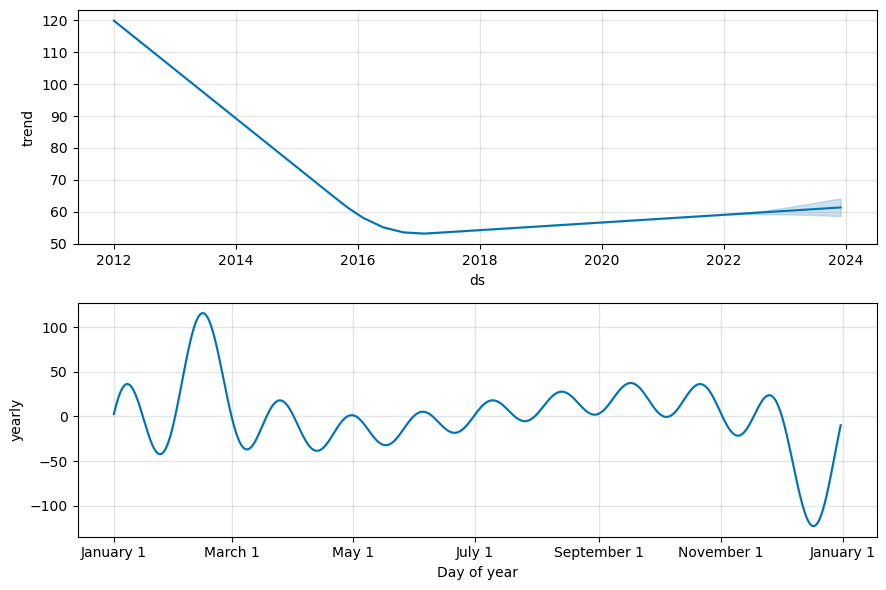

In [68]:
#fig, axes = plt.subplots(2, 1, figsize=(8, 7))
# First plot
#axes[0].set_title('Forecast for the Next 2 Years')
#model.plot(forecast,  ax=axes[0])
fig2 = model.plot_components(forecast)
#axes[0].set_xlabel('date')
#axes[0].set_ylabel('Accumulated Price')

#Second plot 
#axes[1].set_title('calculating weighted price')
#axes[1].plot(combined_predictions['ds'], combined_predictions['accumulated_price'], linestyle='-')
#axes[1].set_xlabel('Date')
#axes[1].set_ylabel('calculated price')

In [69]:
#combined_predictions['accumulated_price'] - forecast['yhat']

In [70]:
model_file_name = 'prophet_model.pkl'
with open(model_file_name, 'wb') as file:
    pickle.dump(model, file)

## Methods to get predictions of material trends

In [71]:
# Method to train required model on trend plus financials forecast regressors
def train_model(train_data, forecasting_period, material_trend):
    data = train_data.copy()
    data.rename(columns={material_trend: 'y'}, inplace=True)
    # Instantiate and fit the Prophet model with additional regressors
    model = Prophet()
    model.add_regressor('PPP')
    model.add_regressor('labor_cost')
    model.add_regressor('CPI')
    model.add_regressor('crude_oil')
    model.fit(data)
    return model

In [72]:
def predict_material_trend(combined_data,data, material, period_of_time):
    model = train_model(data, period_of_time, material)
    forecast = model.predict(combined_predictions)
    return forecast, model

10:56:38 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing


Text(83.09722222222221, 0.5, 'nonalloy_cast')

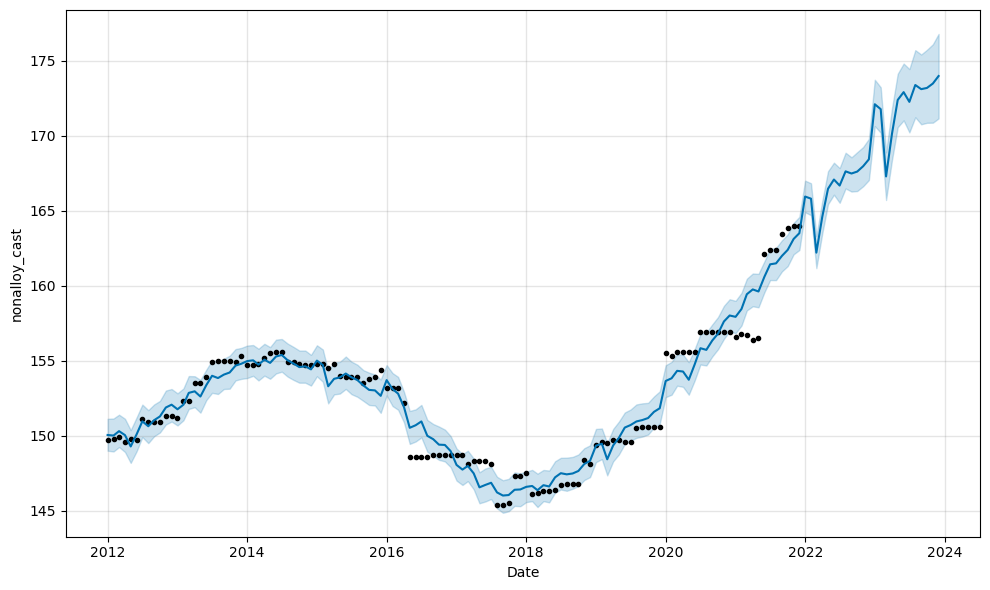

In [73]:
material = 'nonalloy_cast'
forecast, model = predict_material_trend(combined_predictions, data, material, 2)

fig1 = model.plot(forecast)
ax = fig1.gca()  # Get the current Axes
ax.set_xlabel('Date')  # Set the x-axis label
ax.set_ylabel(material)  # Set the y-axis label

# Neural prophet

In [74]:
from neuralprophet import NeuralProphet
from neuralprophet import set_log_level
set_log_level("ERROR")
import pickle

In [75]:
def save_model(model_proph, name):
    #save model pickle file
    model_file_name = name
    with open(model_file_name, 'wb') as file:
        pickle.dump(model_proph, file)

In [76]:
def prep_data_for_prophet(raw_data):
    # Rename the index column to 'ds'
    raw_data.rename(columns={raw_data.columns[0]: 'ds', raw_data.columns[1]: 'y'}, inplace=True)
    raw_data['ds'] = pd.to_datetime(raw_data['ds'].astype(str), format='%Y-%m')
    raw_data['y'] = pd.to_numeric(raw_data['y'], errors='coerce')
    raw_data['y'] = raw_data['y'].astype(float)

In [77]:
def train_neural_model(material_data):
    model_prophet = NeuralProphet(
        n_changepoints=10,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
    )
    metrics = model_prophet.fit(material_data)
    return model_prophet

In [78]:
def get_forecast(neural_model, data_csv, predicted_months = 24):
    future = neural_model.make_future_dataframe(data_csv[['ds','y']], periods=predicted_months, n_historic_predictions=len(data_csv[['ds','y']]))
    forecast = neural_model.predict(future)
    return forecast

In [79]:
prep_data_for_prophet(nonalloy_cast)

# crop dataframe and save csv file 
nonalloy_cast = nonalloy_cast[(nonalloy_cast['ds'] <= '2023-1') ].reset_index(drop=True)
nonalloy_cast.to_csv('data/nonalloy_cast.csv', index=False)

material_name = 'nonalloy_cast'
nonalloy_model = train_neural_model(nonalloy_cast)
save_model(nonalloy_model, material_name + '.pkl')
forecast = get_forecast(nonalloy_model, nonalloy_cast)
nonalloy_model.plot(forecast)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '8ca73a69-2907-441d-bc70-78a89a2d36b6',
              'x': array([datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2004, 1, 1, 0, 0),
                          datetime.datetime(2004, 2, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([100.13686371, 102.3875351 , 102.26481628, ..., 194.34140015,
                          194.62503052, 195.39138794])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid'

In [80]:
prep_data_for_prophet(nodular_cast_iron)

# crop dataframe and save csv file 
nodular_cast_iron = nodular_cast_iron[(nodular_cast_iron['ds'] <= '2023-1') ].reset_index(drop=True)
nodular_cast_iron.to_csv('data/nodular_cast_iron.csv', index=False)

material_name = 'nodular_cast_iron'
nodularcastiron_model = train_neural_model(nodular_cast_iron)
save_model(nodularcastiron_model, material_name + '.pkl')
forecast_cast_iron = get_forecast(nodularcastiron_model, nodular_cast_iron)
nodularcastiron_model.plot(forecast_cast_iron)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '39b4fd69-8ede-41dd-a32c-ed495fb482b4',
              'x': array([datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2004, 1, 1, 0, 0),
                          datetime.datetime(2004, 2, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([100.00257874, 101.6865387 , 102.48181915, ..., 198.52194214,
                          198.46154785, 199.48934937])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid'

In [81]:
# High carbon fitting model and plotting
# prepare the csv file for Neural prophet training
prep_data_for_prophet(high_carbon)

# crop dataframe and save csv file 
high_carbon = high_carbon[(high_carbon['ds'] <= '2023-1') ].reset_index(drop=True)
high_carbon.to_csv('data/high_carbon.csv', index=False)

material_name = 'high_carbon'
high_carbon_model = train_neural_model(high_carbon)
save_model(high_carbon_model, material_name + '.pkl')
forecaset = get_forecast(high_carbon_model, high_carbon)
high_carbon_model.plot(forecast)

Finding best initial lr:   0%|          | 0/208 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '45f4f988-612f-4d08-947a-35c5636b73d5',
              'x': array([datetime.datetime(2003, 12, 1, 0, 0),
                          datetime.datetime(2004, 1, 1, 0, 0),
                          datetime.datetime(2004, 2, 1, 0, 0), ...,
                          datetime.datetime(2024, 11, 1, 0, 0),
                          datetime.datetime(2024, 12, 1, 0, 0),
                          datetime.datetime(2025, 1, 1, 0, 0)], dtype=object),
              'y': array([100.13686371, 102.3875351 , 102.26481628, ..., 194.34140015,
                          194.62503052, 195.39138794])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'uid'

In [82]:
# High carbon fitting model and plotting
# prepare the csv file for Neural prophet training
prep_data_for_prophet(medium_carbon)

material_name = 'medium_carbon'
medium_carbon_model = train_neural_model(medium_carbon)
# this was discontinued so predict until it matches the other materials dates
forecast = get_forecast(medium_carbon_model, medium_carbon, predicted_months=61)

# take the forecasted value and save it(1-1-2023) and retrain the medium carbon on it
predicted_medium_carbon = forecast[['ds', 'y']].copy()

# Fill NaN values in 'y' column with 'yhat1' values
predicted_medium_carbon['y'].fillna(forecast['yhat1'], inplace=True)
predicted_medium_carbon.to_csv('data/medium_carbon.csv', index=False)

# retrain model
medium_carbon_model = train_neural_model(predicted_medium_carbon)
save_model(medium_carbon_model, material_name + '.pkl')
forecast = get_forecast(medium_carbon_model, predicted_medium_carbon)
medium_carbon_model.plot(forecast)

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '66b8f07c-5c65-47bb-9917-9b4aea436a72',
              'x': array([datetime.datetime(2010, 12, 1, 0, 0),
                          datetime.datetime(2011, 1, 1, 0, 0),
                          datetime.datetime(2011, 2, 1, 0, 0),
                          datetime.datetime(2011, 3, 1, 0, 0),
                          datetime.datetime(2011, 4, 1, 0, 0),
                          datetime.datetime(2011, 5, 1, 0, 0),
                          datetime.datetime(2011, 6, 1, 0, 0),
                          datetime.datetime(2011, 7, 1, 0, 0),
                          datetime.datetime(2011, 8, 1, 0, 0),
                          datetime.datetime(2011, 9, 1, 0, 0),
                          datetime.datetime(2011, 10, 1, 0, 0),
                       

In [84]:
prep_data_for_prophet(grey_cast_iron)

# crop dataframe and save csv file 
grey_cast_iron_cropped = grey_cast_iron[(grey_cast_iron['ds'] <= '2023-1') ].reset_index(drop=STrue)
grey_cast_iron_cropped.to_csv('data/grey_cast_iron.csv', index=False)

material_name = 'grey_cast_iron'
grey_castiron_model = train_neural_model(grey_cast_iron_cropped)
save_model(grey_castiron_model, material_name + '.pkl')
forecast_grey_cast_iron = get_forecast(grey_castiron_model, grey_cast_iron_cropped)
grey_castiron_model.plot(forecast_grey_cast_iron)S

SyntaxError: invalid syntax (2570425838.py, line 11)

In [85]:
high_carbon

,ds,y
0,2011-12-01,100.000
1,2012-01-01,100.000
2,2012-02-01,100.400
3,2012-03-01,100.400
4,2012-04-01,100.600
...,...,...
129,2022-09-01,123.131
130,2022-10-01,123.131
131,2022-11-01,123.160
132,2022-12-01,123.160


In [87]:
nonalloy_cast

,ds,y
0,2003-12-01,100.000
1,2004-01-01,100.800
2,2004-02-01,101.400
3,2004-03-01,101.800
4,2004-04-01,102.600
...,...,...
225,2022-09-01,191.967
226,2022-10-01,189.982
227,2022-11-01,189.980
228,2022-12-01,189.955
